# 1. Compute time scaling

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import re
import plot_formatting as pf
import matplotlib.pyplot as plt

In [ ]:
### PARALLEL RESULTS 
directory = '../data/'
file_pattern = os.path.join(directory, '*performance.csv')
file_list = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in file_list]
merged_df_CUDA = pd.concat(dataframes, ignore_index=True)
merged_df_CUDA.head()

,step,mcmc_time_ms,observables_time_ms,lattice_size,temperature,interaction_J,magnetic_field_h,random_seed,hot_start,use_lut,block_size,threads_per_block,blocks_per_grid_mcmc,blocks_per_grid_obs
0,0,0.159896,0.262031,64,2.0,1.0,0.0,13072025,0,1,128,128,16,8
1,200,0.121198,0.293541,64,2.0,1.0,0.0,13072025,0,1,128,128,16,8
2,400,0.121093,0.295312,64,2.0,1.0,0.0,13072025,0,1,128,128,16,8
3,600,0.116563,0.256823,64,2.0,1.0,0.0,13072025,0,1,128,128,16,8
4,800,0.123490,0.250416,64,2.0,1.0,0.0,13072025,0,1,128,128,16,8


In [ ]:
### SERIAL RESULT
directory = '../data/'
file_pattern = os.path.join(directory, 'serial_performance*')
file_list = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in file_list]
merged_df_serial = pd.concat(dataframes, ignore_index=True)
merged_df_serial.head()

,L,T,J,h,steps,mcmc_step_ms
0,128,2.0,1.0,0.0,0,1.983541
1,128,2.0,1.0,0.0,1,1.994584
2,128,2.0,1.0,0.0,2,1.945885
3,128,2.0,1.0,0.0,3,1.953802
4,128,2.0,1.0,0.0,4,1.941198


In [26]:
grouped_cuda = merged_df_CUDA.groupby(['lattice_size', 'use_lut'])['mcmc_time_ms'].mean()
mcmc_time_cuda_lut = grouped_cuda.xs(1, level='use_lut').values
mcmc_time_cuda = grouped_cuda.xs(0, level='use_lut').values
obs_time_cuda = merged_df_CUDA.groupby('lattice_size')['observables_time_ms'].mean()
mcmc_time_serial = merged_df_serial.groupby('L')['mcmc_step_ms'].mean()
lattice_sizes = grouped_cuda.index.get_level_values('lattice_size').unique()
N = lattice_sizes.to_numpy()

In [ ]:
print(N)

[  32   64  128  256  512 1024]


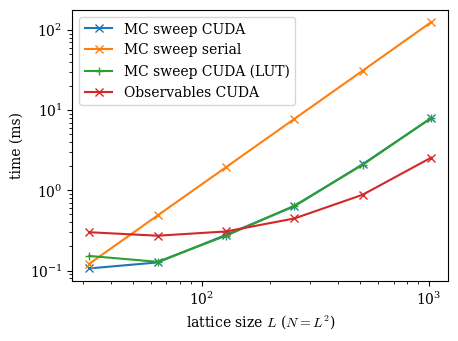

In [ ]:
#Compute time
size, line = pf.plot_formatting(0.7, 4/3)
fig, ax = plt.subplots(figsize = size)
ax.set_xlabel('lattice size $L$ ($N = L^2$)')
ax.set_ylabel('time (ms)')
ax.plot(N, mcmc_time_cuda, '-x', label='MC sweep CUDA')
ax.plot(N, mcmc_time_serial, '-x', label='MC sweep serial')
ax.plot(N, mcmc_time_cuda_lut, '-+', label='MC sweep CUDA (LUT)')
ax.plot(N, obs_time_cuda, '-x', label='Observables CUDA')
ax.legend()
plt.loglog()
plt.tight_layout()
fig.savefig('plots/timescaling.svg')
plt.show()

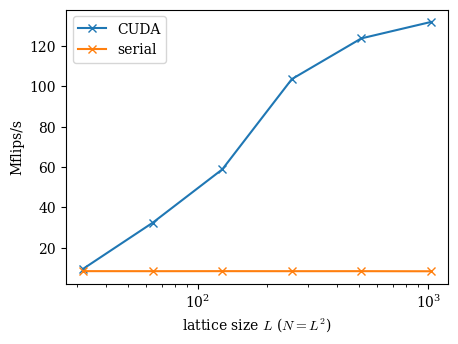

In [ ]:
#Millions of spin flips per second
def mflips(time_ms, N):
    return N**2/time_ms/10**3
size, line = pf.plot_formatting(0.7, 4/3)
fig, ax = plt.subplots(figsize = size)
ax.set_xlabel('lattice size $L$ ($N = L^2$)')
ax.set_ylabel('Mflips/s')
ax.plot(N, mflips(mcmc_time_cuda, N), '-x', label='CUDA')
ax.plot(N, mflips(mcmc_time_serial, N), '-x', label='serial')
ax.legend()
plt.tight_layout()
plt.semilogx()
fig.savefig('plots/mflips.svg')
plt.show()

# 2. Bandwidth scaling

In [75]:
#MCMC step (no LUT)
# 1. Read current spin: 1 byte
# 2. Read 4 neighbors: 4 bytes  
# 3. Write updated spin: 1 byte
def membw(time_ms, N):
    #GB/s
    return 6*N**2*1000/time_ms/(1024**3)

#MCMC step (w LUT)
# Memory operations per spin update:
# 1. Read current spin: 1 byte
# 2. Read 4 neighbors: 4 bytes
# 3. Read LUT entry: 4 bytes (float)
# 4. Write updated spin: 1 byte
def membw_lut(time_ms, N):
    #GB/s
    return 10*N**2*1000/time_ms/(1024**3)

#Observables
# MAGNETIZATION:
# 1. Read all spins once: half_spins * 1 byte (signed char) per color
# 2. Write partial results: num_blocks * 4 bytes (float) per reduction
# 3. Final CPU reduction of block results: num_blocks reads (float)
# ENERGY:
# 1. Read black spins: half_spins * 1 byte
# 2. Read white spins for neighbor calculation: 4 * half_spins * 1 byte
# 3. Write partial energy results: num_blocks * 4 bytes
# 4. CPU final reduction: num_blocks (float)
def membw_obs(time_ms, N, blocks):
    #GB/s
    energy_bytes = N**2/2 + N**2*4/2 + 4*blocks + blocks
    magnetization_bytes = N**2/2*2 + 4*blocks + blocks
    return (energy_bytes + magnetization_bytes)*1000/time_ms/(1024**3)

# get blocks per grid
filtered_df = merged_df_CUDA[merged_df_CUDA['threads_per_block'] == 128]
blocks = filtered_df.groupby('lattice_size')['blocks_per_grid_obs'].max()

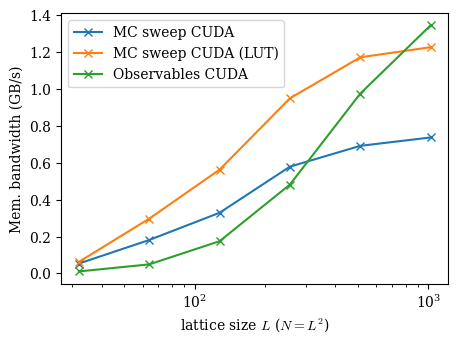

In [78]:
size, line = pf.plot_formatting(0.7, 4/3)
fig, ax = plt.subplots(figsize = size)
ax.set_xlabel('lattice size $L$ ($N = L^2$)')
ax.set_ylabel('Mem. bandwidth (GB/s)')
ax.plot(N, membw(mcmc_time_cuda, N), '-x', label='MC sweep CUDA')
ax.plot(N, membw_lut(mcmc_time_cuda_lut, N), '-x', label='MC sweep CUDA (LUT)')
ax.plot(N, membw_obs(obs_time_cuda, N, blocks), '-x', label='Observables CUDA')
ax.legend()
plt.tight_layout()
plt.semilogx()
fig.savefig('plots/bandscaling.svg')
plt.show()

# 3. Threads per block

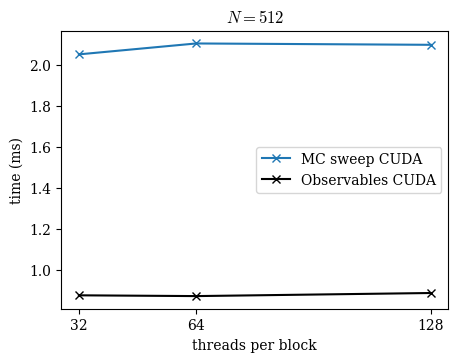

In [81]:
filtered_df = merged_df_CUDA[merged_df_CUDA['lattice_size'] == 512]
mcmc_band_tpb = filtered_df.groupby('threads_per_block')['mcmc_time_ms'].mean()
obs_band_tpb = filtered_df.groupby('threads_per_block')['observables_time_ms'].mean()
tpb = mcmc_band_tpb.index.tolist()

size, line = pf.plot_formatting(0.7, 4/3)
fig, ax = plt.subplots(figsize = size)
ax.set_xlabel('threads per block')
ax.set_ylabel('time (ms)')
ax.plot(tpb, mcmc_band_tpb, '-x', label='MC sweep CUDA')
ax.plot(tpb, obs_band_tpb, '-x', color='black', label='Observables CUDA')
ax.legend()
plt.tight_layout()
plt.title(rf'$N=512$')
ax.set_xticks([32, 64, 128])
fig.savefig('tpbscaling.svg')
plt.show()